<h2 style="text-align:center;font-size:200%;;">Pyspark для исследовательского анализа данных </h2>

Кузьменко Сергей БД-231м

**Данные:** IBM Transactions for Anti Money Laundering (AML)

**Источник:** https://www.kaggle.com/

# **1. Инициализация платформы Spark и загрузка данных в фрейм данных Spark** <a class="anchor" id="1"></a>

In [1]:
# Импорт модулей, не связанныех с PySpark.
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# Это помогает автоматически распечатывать элементы без явного использования «печати».
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=9adce98b306ff17d85ff5b5af14ede3c4b7979237ccbe6d8965abbec265fc6b4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, count, sum, min, max
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '/content/drive/MyDrive/Colab Notebooks/PySpark_lab/HI-Medium_Trans.csv' # Загрузите данные в текущий каталог Colab.

df = spark.read.option("header", True).csv(filename_data)
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# **2. Обзор набора данных** <a class="anchor" id="2"></a>

### Схема, столбцы и типы данных набора:
   *Набор данных содержит как столбцы с одним значением (int, string), так и столбцы, состоящие из списка массивов.*

In [5]:
print('Обзор данных')
df.printSchema()
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор данных
root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)

Обзор столбцов


,Column Name,Data type
0,Timestamp,string
1,From Bank,string
2,Account2,string
3,To Bank,string
4,Account4,string
5,Amount Received,string
6,Receiving Currency,string
7,Amount Paid,string
8,Payment Currency,string
9,Payment Format,string


In [6]:
print(f'Общее количество {df.count()} строк, печатаем несколько первых строк:')
df.limit(2).toPandas()

Общее количество 31898238 строк, печатаем несколько первых строк:


,Timestamp,From Bank,Account2,To Bank,Account4,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:17,020,800104D70,020,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/09/01 00:02,03196,800107150,03196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0


# **3. Исследовательский анализ.** <a class="anchor" id="3"></a>





Основные статистические показатели

In [7]:
print('Описание фрейма данных (только строковые и числовые столбцы):')
df.describe().toPandas()

Описание фрейма данных (только строковые и числовые столбцы):


,summary,Timestamp,From Bank,Account2,To Bank,Account4,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,count,31898238,31898238,31898238,31898238,31898238,31898238,31898238,31898238,31898238,31898238,31898238
1,mean,None,294409.4462990714,Infinity,409319.75427216385,Infinity,6431116.01001477,None,4417550.924693565,None,None,0.0011044497191349566
2,stddev,None,615314.9321944972,NaN,654700.2546590611,NaN,2.5927442427113585E9,None,1.8483134902596605E9,None,None,0.03321490545732131
3,min,2022/09/01 00:00,000,100428660,000,100428660,0.000001,Australian Dollar,0.000001,Australian Dollar,ACH,0
4,max,2022/09/28 15:58,070,8521FC1B0,070,8521FC1B0,99999.26,Yuan,99999.26,Yuan,Wire,1


Видим, что дата меняется в диапазоне **от 1 сентября 2022 до 28 сентября 2022**

После предварительного просмотра столбцов первое, что должны проверить, — это наличие в наборе данных какого-либо пропущенного значения.
– Для строковых столбцов  проверяем наличие `None` и `null`.
- Для числовых столбцов проверяем наличие нулей и `NaN`.
- Для столбцов типа массив проверяем, содержит ли массив нули или `NaN`.

In [8]:
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,Timestamp,string
1,From Bank,string
2,Account2,string
3,To Bank,string
4,Account4,string
5,Amount Received,string
6,Receiving Currency,string
7,Amount Paid,string
8,Payment Currency,string
9,Payment Format,string


In [9]:
string_columns = ['Timestamp', 'From Bank', 'Account2', 'To Bank', 'Account4', 'Receiving Currency', 'Payment Format' ]
numeric_columns = ['Amount Received', 'Amount Paid', 'Is Laundering']
array_columns = []
missing_values = {}
for index, column in enumerate(df.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,Timestamp,From Bank,Account2,To Bank,Account4,Amount Received,Receiving Currency,Amount Paid,Payment Format,Is Laundering
0,0,0,0,0,0,0,0,0,0,0


Переведем столбец `Timestamp` в формат дата с помощью `UDF - функции`

In [10]:
# Преобразование столбца метки времени в Datetime.Datetime, чтобы позже использовать его для функции .withColumn.
def to_datetime(t):
    return datetime.strptime(t, "%Y/%m/%d %H:%M")

# Регистрация вспомогательной функции to_time в структуре UDF pyspark
udf_to_datetime = udf(to_datetime, TimestampType())

Выделим номер дня с помощью `UDF - функции`

In [11]:
# Преобразование столбца метки времени в Datetime.Datetime, чтобы позже использовать его для функции .withColumn.
def to_day(t):
    return datetime.strptime(t, "%Y/%m/%d %H:%M").day

# Регистрация вспомогательной функции to_time в структуре UDF pyspark
udf_to_day = udf(to_day, IntegerType())


In [12]:
df = df.withColumn('Datetime',
    udf_to_day(df.Timestamp))
df = df.withColumn('DAY',
    udf_to_day(df.Timestamp))
print('Обзор столбцов')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Обзор столбцов


,Column Name,Data type
0,Timestamp,string
1,From Bank,string
2,Account2,string
3,To Bank,string
4,Account4,string
5,Amount Received,string
6,Receiving Currency,string
7,Amount Paid,string
8,Payment Currency,string
9,Payment Format,string


In [13]:
df.limit(10).toPandas()

,Timestamp,From Bank,Account2,To Bank,Account4,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Datetime,DAY
0,2022/09/01 00:17,020,800104D70,020,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0,1,1
1,2022/09/01 00:02,03196,800107150,03196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0,1,1
2,2022/09/01 00:17,01208,80010E430,01208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0,1,1
3,2022/09/01 00:03,01208,80010E650,020,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0,1,1
4,2022/09/01 00:02,01208,80010E650,020,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0,1,1
5,2022/09/01 00:27,03203,80010EA80,03203,80010EA80,13284.41,US Dollar,13284.41,US Dollar,Reinvestment,0,1,1
6,2022/09/01 00:25,020,800104D20,020,800104D20,9.72,US Dollar,9.72,US Dollar,Reinvestment,0,1,1
7,2022/09/01 00:09,01208,80010E430,01208,80010E430,7.66,US Dollar,7.66,US Dollar,Reinvestment,0,1,1
8,2022/09/01 00:09,011,80010E600,011,80010E600,16.33,US Dollar,16.33,US Dollar,Reinvestment,0,1,1
9,2022/09/01 00:06,01208,80010E650,01208,80010E650,4.86,US Dollar,4.86,US Dollar,Reinvestment,0,1,1


Проанализируем количество мошеннических операций `Is Laundering` = 1 в разрезе по дням

In [43]:
LAUND_DF = df \
    .select(df.DAY, df.Timestamp) \
    .filter(df['Is Laundering'] == 1) \
    .distinct() \
    .groupBy(df.DAY) \
    .agg(count('Timestamp').alias('cnt')).toPandas()

In [ ]:
LAUND_DF = LAUND_DF.set_index('DAY').sort_index()
LAUND_DF

[Text(0.5, 1.0, 'Количество мошеннических операций'),
 Text(0.5, 0, 'День'),
 Text(0, 0.5, 'Количество операций')]

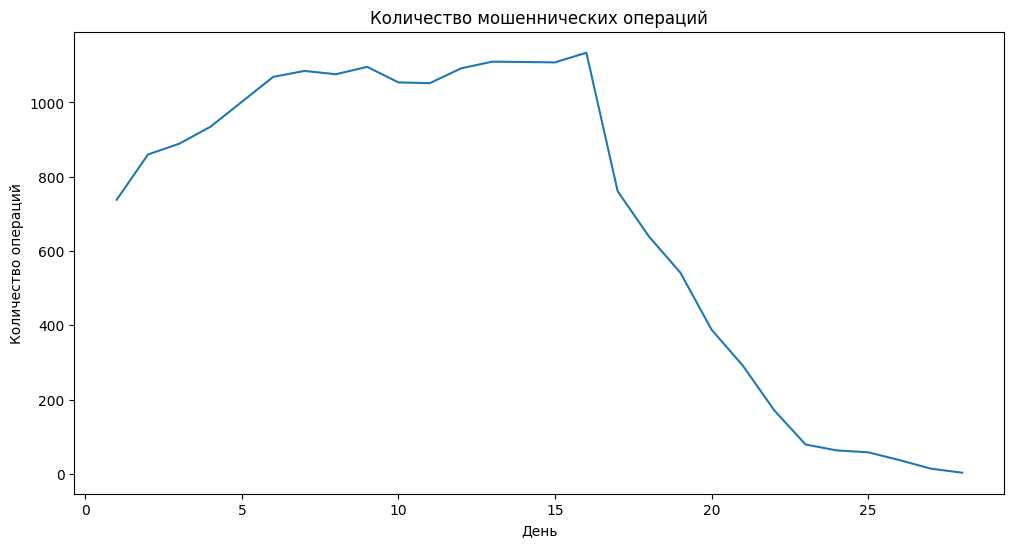

In [46]:
# изменим размер графика, уберем легенду и добавим подписи
ax = LAUND_DF.plot(figsize = (12,6), legend = None)
ax.set(title = 'Количество мошеннических операций', xlabel = 'День', ylabel = 'Количество операций')


Аналогично для НЕмошеннических операций `Is Laundering` = 0

[Text(0.5, 1.0, 'Количество нормальных операций'),
 Text(0.5, 0, 'День'),
 Text(0, 0.5, 'Количество операций')]

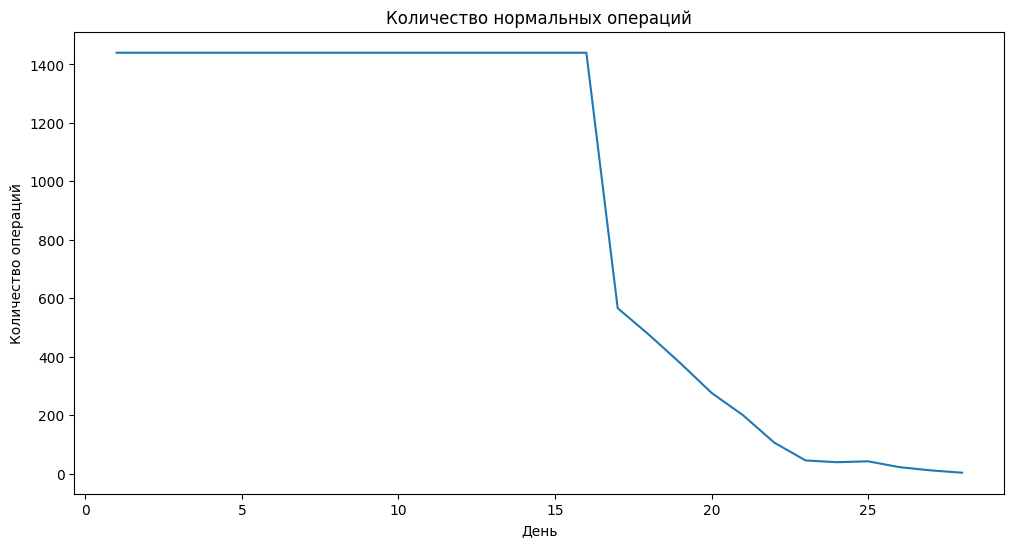

In [48]:
NOLAUND_DF = df \
    .select(df.DAY, df.Timestamp) \
    .filter(df['Is Laundering'] == 0) \
    .distinct() \
    .groupBy(df.DAY) \
    .agg(count('Timestamp').alias('cnt')).toPandas()

NOLAUND_DF = NOLAUND_DF.set_index('DAY').sort_index()
ax = NOLAUND_DF.plot(figsize = (12,6), legend = None)
ax.set(title = 'Количество нормальных операций', xlabel = 'День', ylabel = 'Количество операций')